# SYDE 552 Assignment 4: Basal Ganglia
### Due Monday, April 8, 11:59pm
### Value: 15% of total marks for the course

This assignment covers various forms of Action Selection, covering a standard feed-forward neural network model and a winner-take-all model.  The last section adds biological details to the winner-take-all model (synapses).  The intent is to show the creation a modification of small specific-purpose networks and to explore how timing affects neurons.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. Action Selection with Feed-forward Neural Networks

In order for the brain to choose which of many possible actions to select to perform at any given moment, it needs to be able to take a list of numbers (indicating how good each action is in the current state, sometimes called the Value) and create an output that indicates which one is the largest.  For example, with the input `[0.2, 0.5, 0.8, 0.3]` we might want the output `[0, 0, 1, 0]`.  

One way to approach this task is to train a normal feed-forward neural network on this task.  This would be similar to the digit recognition task from Assignment 2, except we would just have the list of values as input instead of the image.

To create the dataset for training the network, we can just generate a random set of values between 0 and 1, and then compute which one is biggest to produce our target value.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [29]:
N = 4        # how many values in the list
M = 10000    # how many random examples to make in the dataset

X = np.random.uniform(0,1,(M,N))
Y = np.argmax(X, axis=1)

In order to train with this data in pytorch, we need to turn that array into a pytorch dataset, and to split it into training and testing.


In [30]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Y).long()) # create your datset

train_dataset, test_dataset = torch.utils.data.random_split(dataset,[0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

Now we have to define our network.  Here we define a simple neural network with 4 inputs, a hidden layer of 100 neurons, and 4 outputs.

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_neurons=100):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, n_neurons)    # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(n_neurons, 4)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return x

Finally, we have to train the model.  Here is the exact same code from Assignment 2 for training


In [76]:
def continue_training(network, optimizer, accuracy_train, accuracy_test):
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:           # working in batchs of 1000
            optimizer.zero_grad()                   # initialize the learning system
            output = network(data)                  # feed in the data 
            loss = F.nll_loss(output, target)       # compute how wrong the output is
            loss.backward()                         # change the weights to reduce error
            optimizer.step()                        # update the learning rule
            
            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)
    
    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    
    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score)

**1. a) [1 mark]** Call `continue_training()` 10 times and then plot the training and testing accuracy (as you did in assignment 2 question 3a).

In [77]:
network = Net()
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
acc_train = []
acc_test = []

for i in range(10):
    continue_training(network, optimizer, acc_train, acc_test)

Iteration 1 Training accuracy: 0.2537499964237213
Iteration 1 Testing accuracy: 0.25850000977516174
[0.2537499964237213]
[0.25850000977516174]
Iteration 2 Training accuracy: 0.2581250071525574
Iteration 2 Testing accuracy: 0.25850000977516174
[0.2537499964237213, 0.2581250071525574]
[0.25850000977516174, 0.25850000977516174]
Iteration 3 Training accuracy: 0.2581250071525574
Iteration 3 Testing accuracy: 0.25850000977516174
[0.2537499964237213, 0.2581250071525574, 0.2581250071525574]
[0.25850000977516174, 0.25850000977516174, 0.25850000977516174]
Iteration 4 Training accuracy: 0.2581250071525574
Iteration 4 Testing accuracy: 0.25850000977516174
[0.2537499964237213, 0.2581250071525574, 0.2581250071525574, 0.2581250071525574]
[0.25850000977516174, 0.25850000977516174, 0.25850000977516174, 0.25850000977516174]
Iteration 5 Training accuracy: 0.24387499690055847
Iteration 5 Testing accuracy: 0.2475000023841858
[0.2537499964237213, 0.2581250071525574, 0.2581250071525574, 0.2581250071525574, 0

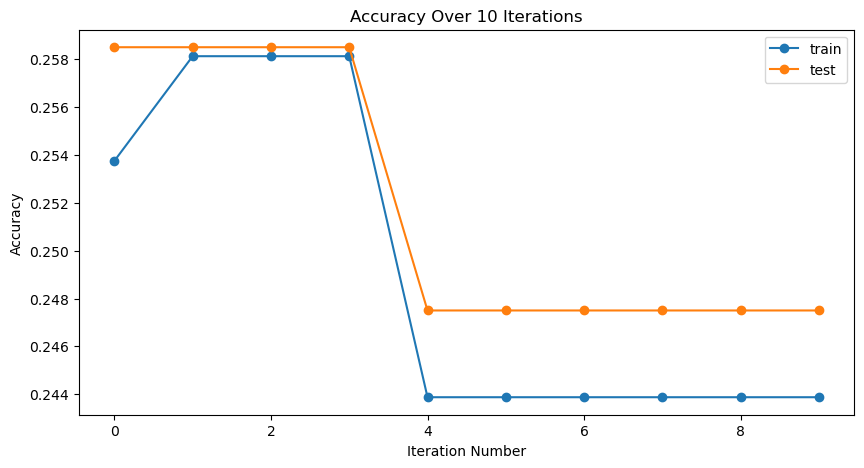

In [78]:
# plot the training and testing accuracy over 10 iterations
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(acc_train, 'o-', label='train')
ax.plot(acc_test, 'o-', label='test')
ax.set_title('Accuracy Over 10 Iterations')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Accuracy')
ax.legend()

**1. b) [1 mark]** In the previous question, the model did not get a very high accuracy.  To try to improve the accuracy, let's vary the number of neurons.  Try using 200 neurons, 500 neurons, and 1000 neurons.  For each one, generate the same plot as in 1a.  Does making the network larger in this way improve performance significantly?

In [79]:
n_neurons = [200, 500, 1000]
train = np.zeros((len(n_neurons), 10))
test = np.zeros((len(n_neurons), 10))

# sweep through n_neurons and recreate the plot above:
for i, n in enumerate(n_neurons):
    acc_train = []
    acc_test = []
    net = Net(n_neurons=n)
    optim = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.5)
    for j in range(10):
        continue_training(net, optim, acc_train, acc_test)
    train[i] = np.array(acc_train)
    test[i] = np.array(acc_test)

Iteration 1 Training accuracy: 0.2581250071525574
Iteration 1 Testing accuracy: 0.25850000977516174
Iteration 2 Training accuracy: 0.2581250071525574
Iteration 2 Testing accuracy: 0.25850000977516174
Iteration 3 Training accuracy: 0.2581250071525574
Iteration 3 Testing accuracy: 0.25850000977516174
Iteration 4 Training accuracy: 0.2581250071525574
Iteration 4 Testing accuracy: 0.25850000977516174
Iteration 5 Training accuracy: 0.24387499690055847
Iteration 5 Testing accuracy: 0.2475000023841858
Iteration 6 Training accuracy: 0.24387499690055847
Iteration 6 Testing accuracy: 0.2475000023841858
Iteration 7 Training accuracy: 0.24387499690055847
Iteration 7 Testing accuracy: 0.2475000023841858
Iteration 8 Training accuracy: 0.24387499690055847
Iteration 8 Testing accuracy: 0.2475000023841858
Iteration 9 Training accuracy: 0.24387499690055847
Iteration 9 Testing accuracy: 0.2475000023841858
Iteration 10 Training accuracy: 0.24387499690055847
Iteration 10 Testing accuracy: 0.247500002384185

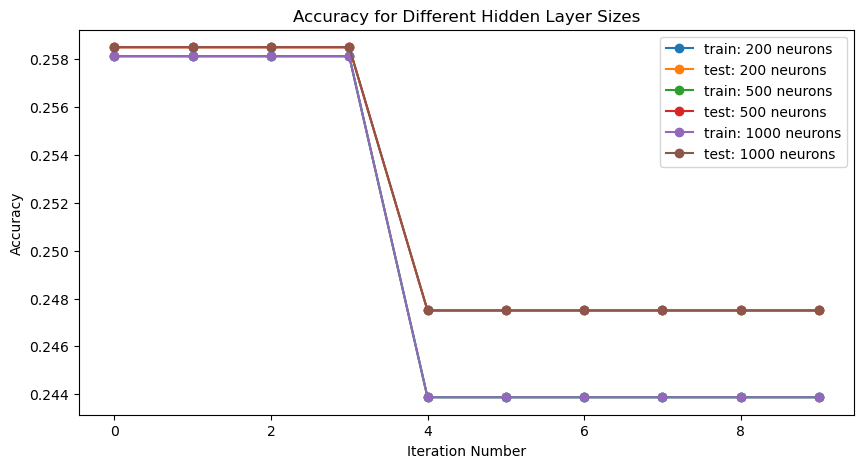

In [80]:
# plot the accuracy over 10 iterations for different numbers of neurons:
fig, ax = plt.subplots(figsize=(10,5))

for i in range(len(n_neurons)):
    ax.plot(train[i], 'o-', label=f'train: {n_neurons[i]} neurons')
    ax.plot(test[i], 'o-', label=f'test: {n_neurons[i]} neurons')

ax.set_title('Accuracy for Different Hidden Layer Sizes')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Accuracy')
ax.legend()

### Discussion:

From the plot above, we can see that increasing the size of the hidden layer does not improve performance. In fact, the performance decreases with more training.

The networks with varying hidden layer sizes demonstrate identical accuracy.

**1. c) [1 mark]** Try making the network deeper by adding a second layer of neurons.  Use 500 neurons in each of the two middle layers.  Generate the same plot as in 1a.  Does making the network larger in this way improve performance significantly?

In [81]:
class TwoLayerNet(nn.Module):
    def __init__(self):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(4, 500)
        self.fc2 = nn.Linear(500, 500) # add a second hidden layer
        self.fc3 = nn.Linear(500, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# train a 2-layer network:
network = TwoLayerNet()
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
train_2_layer = []
test_2_layer = []

for i in range(10):
    continue_training(network, optimizer, train_2_layer, test_2_layer)

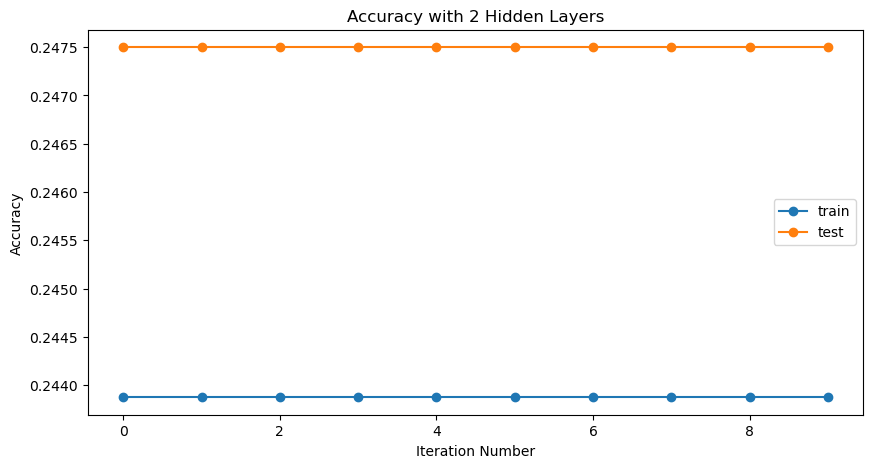

In [83]:
# plot accuracy vs. iteration number:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_2_layer, 'o-', label='train')
ax.plot(test_2_layer, 'o-', label='test')
ax.set_title('Accuracy with 2 Hidden Layers')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Accuracy')
ax.legend()

**1. d) [1 mark]** Starting with the original model in question 1a, let's modify the network in a different way.  In particular, in the current version of the model we have no neuron model at the output.  This is due to this part of the code:

```python
    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x))  # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)          # apply the second set of weights
        return x
```

For the first line (the hidden layer), we use a Rectified Linear neuron model (`F.relu`).  But we aren't doing that with the second line, where it creates the output.  Let's try adding a neuron model there by changing `x = self.fc2(x)` to `x = F.relu(self.fc2(x))`.

Train the model again (by calling `continue_training` 10 times) and make the same plot as above.  Does this improve performance significantly?

In [84]:
class ModifiedNet(nn.Module):
    def __init__(self, n_neurons=100):
        super(ModifiedNet, self).__init__()
        self.fc1 = nn.Linear(4, n_neurons)    # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(n_neurons, 4)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = F.relu(self.fc2(x))         # apply the second set of weights, then apply the ReLU neuron model
        return x

# train a Modified ReLU network:
network = ModifiedNet()
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
train_modified = []
test_modified = []

for i in range(10):
    continue_training(network, optimizer, train_modified, test_modified)

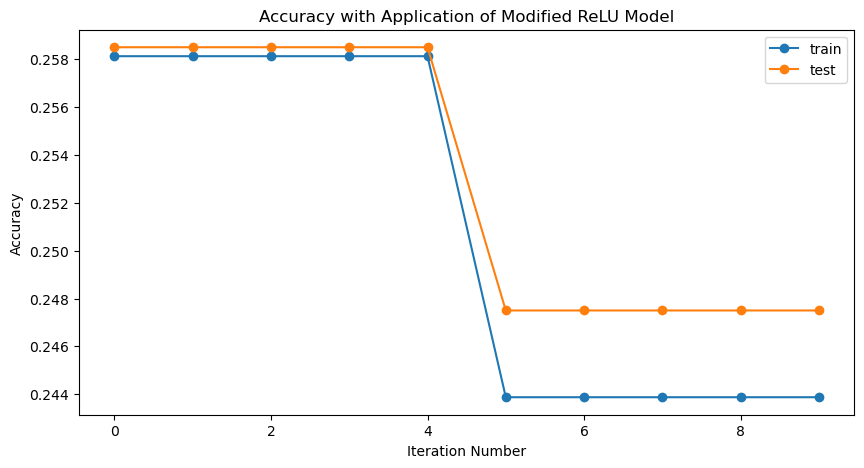

In [86]:
# plot accuracy vs. iteration number:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_modified, 'o-', label='train')
ax.plot(test_modified, 'o-', label='test')
ax.set_title('Accuracy with Application of Modified ReLU Model')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Accuracy')
ax.legend()

### Discussion:

## ***TO DO***

**1. e) [1 mark]** Repeat 1.d but use `F.sigmoid` instead of `F.relu` for the output.  Plot the same graph as before.  You should see that this change makes an improvement over the results in the previous questions.  Why is this the case?

In [115]:
class Sigmoid(nn.Module):
    def __init__(self, n_neurons=100):
        super(Sigmoid, self).__init__()
        self.fc1 = nn.Linear(4, n_neurons) # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(n_neurons, 4) # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x))            # apply the first set of weights, then apply the ReLU neuron model
        x = F.sigmoid(self.fc2(x))         # apply the second set of weights, then apply the sigmoid neuron model
        return x

# train a Sigmoid network:
network = Sigmoid()
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
train_sigmoid = []
test_sigmoid = []

for i in range(10):
    continue_training(network, optimizer, train_sigmoid, test_sigmoid)

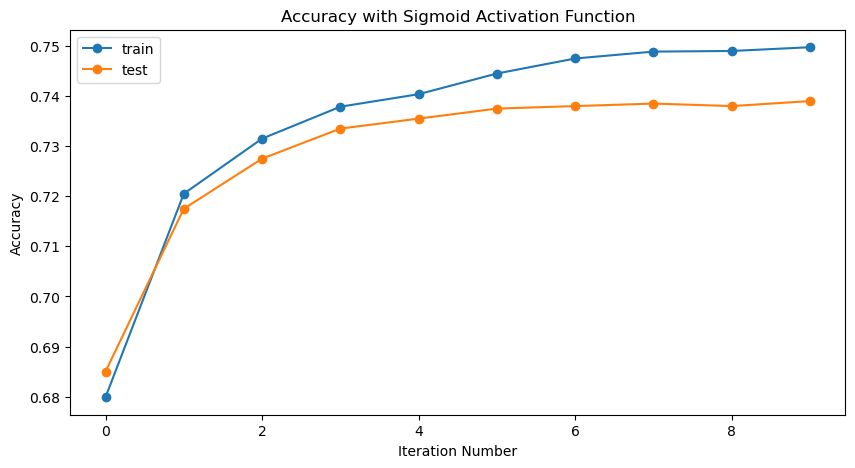

In [117]:
# plot accuracy vs. iteration number:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_sigmoid, 'o-', label='train')
ax.plot(test_sigmoid, 'o-', label='test')
ax.set_title('Accuracy with Sigmoid Activation Function')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Accuracy')
ax.legend()

### Discussion:

## ***TO DO***

**1. f) [1 mark]** Try replacing the `F.sigmoid` with `F.softmax`.  The softmax function will scale up the largest value while scaling down the smaller values.  Repeat the previous question and plot the same graph.  You should see an even bigger improvement.  Why is this the case?  

In [118]:
class Softmax(nn.Module):
    def __init__(self, n_neurons=100):
        super(Softmax, self).__init__()
        self.fc1 = nn.Linear(4, n_neurons) # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(n_neurons, 4) # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x)       )     # apply the first set of weights, then apply the ReLU neuron model
        x = F.softmax(self.fc2(x), dim=0)  # apply the second set of weights, then apply the softmax neuron model
        return x

# train a Softmax network:
network = Softmax()
optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
train_softmax = []
test_softmax = []

for i in range(10):
    continue_training(network, optimizer, train_softmax, test_softmax)

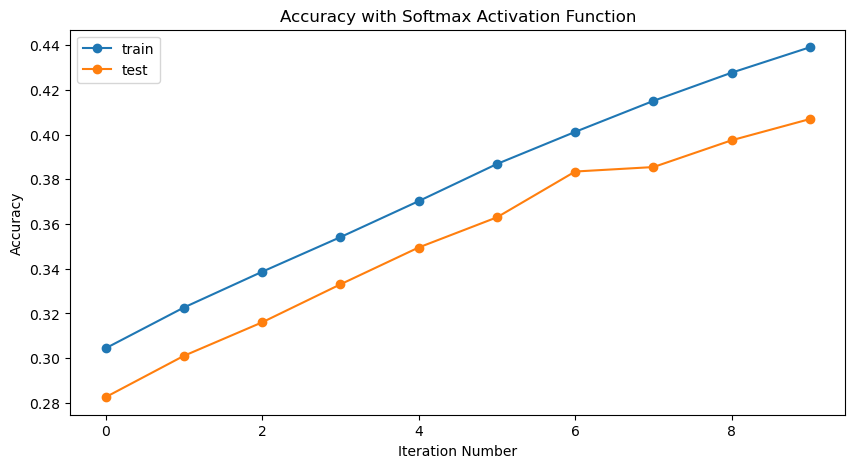

In [120]:
# plot accuracy vs. iteration number:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_softmax, 'o-', label='train')
ax.plot(test_softmax, 'o-', label='test')
ax.set_title('Accuracy with Softmax Activation Function')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Accuracy')
ax.legend()

### Discussion:

The softmax activation function...

**1. g) [1 mark]** Even though the model you built in 1f) does a good job of solving the task of producing the correct output, it seems to do this only if we include a `softmax` operation.  How might this be considered "cheating" (and thus this should not considered to be a good model of action selection in the brain)? 

## ***TO DO***

# 2. Action Selection with Winner-Take-All

Given the results of the previous section, we need a different approach to do action selection.  Since a feed-forward approach led to difficulties, here we will explore a recurrent network: the standard "winner-take-all" circuit.  In this system, each neuron excites itself but inhibits the other neurons.

Crucially, since this approach is recurrent, we can't just feed in an input and get an output.  Instead, we will feed in an input over time and see what the output is over time.  Rather than implement this in `pytorch`, we will just use normal numpy commands.

The main configurable part of the model is how nuch the neurons excite themselves and how much they inhibit other neurons.  We can build this as a weight matrix that has the excitation on the diagonal and the inhibition everywhere else:


In [121]:
w = np.zeros((N,N))
w[:] = -0.9   # set the inhibition amount everywhere
for i in range(N):
    w[i,i] = 1   # set the excitatory connection
    
print(w)

[[ 1.  -0.9 -0.9 -0.9]
 [-0.9  1.  -0.9 -0.9]
 [-0.9 -0.9  1.  -0.9]
 [-0.9 -0.9 -0.9  1. ]]


To run the model, we pick a particular input set that we will provide. We then feed that value into the model, and add the value that the neurons send back to themselves.  We also include a `clip` operation that stops the neuron value from going below 0 or above 1.  We repeat this process multiple times, and we record the activity of the neurons so we can plot it afterwards.

In [122]:
record = []                   # for recording the activity values
activity = np.zeros(N)        # neurons are not active initially
inut_values = 
for i in range(10):
    # the new neuron value is the old value times the weight matrix (for the neurons inhibiting/exciting each other), plus the input benig added.
    # we also clip the neurons so their activity doesn't go below 0 or above 1
    activity = np.clip(input_values + w @ activity, 0, 1)
    record.append(activity)

NameError: name 'input_values' is not defined

**2. a) [1 mark]**  Run the model with an input of `[0.7, 0.8, 0.4, 0.3]`.  Plot the `record` of the activity.  Print the final `activity` value.  Does the network successfully output the desired correct results of `[0, 1, 0, 0]`?

**2. b) [1 mark]**  Test the model using all the data in the `X` dataset you created in question 1.  (This should be all 10000 sets of 4 randomly generated numbers).  Note that since we didn't use any data to train the model, we are using all of it to test the model.

To test the model, loop through all the items (`for input_values in X:`) and run the model as in question 2a.  To determine if the output is correct, you can do

```python
    target = np.zeros(N)
    target[np.argmax(input_values)] = 1
    if np.all(target == activity):
        correct += 1
```

What proportion of the time does the model produce the correct output?

**2. c) [1 mark]**  Try running the model for a longer time, rather than the 10 steps in the code provided.  Try 10, 20, 50, 100, 200, and 500.  Make a plot showing the proportion of time the model produces the ideal output for each of those numbers of timesteps.

**2. d) [2 marks]**  Try improving the model by adjusting the amount of inhibition (-0.9) and the amount of excitation (1).  Can you improve the proportion of time the model produces the correction output?  To simplify your experimentation, keep the number of timesteps as 20.

# 3. Action Selection with Winner-Take-All and a Synapse

We are now going to add a biological detail to the Winner-Take-All system.  In biology, when there is a connection between neurons, there is a synapse, and the activity of that synapse decays slowly over time.  This means that when a spike occurs, the input into the next neuron will suddenly increase, and then slowly decrease.

Here we will make a simple approximation of this process.  We will be implementing this as a *low-pass filter*.  The only parameter is the one that controls how quickly the synaptic activity will decay, and we will call this `tau`.  To implement a low-pass filter as part of our neuron model, we can compute the synaptic activity as follows, where `dt` is how long one timestep is in our model:

```python
alpha = 1-np.exp(-dt/tau)

activity_syn = activity_syn + alpha * (activity - activity_syn)
```

Here is what that would look like for a single input that gave a single spike on the 5th timestep, where each timestep is 0.001 seconds and the synaptic time constant is 0.01 seconds (10 milliseconds):



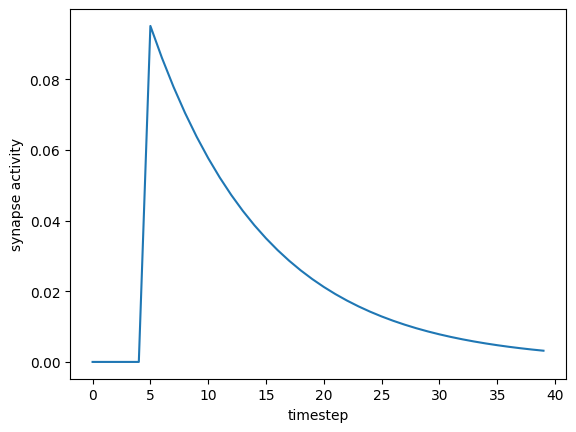

In [8]:
activity - np.zeros(1)
activity_syn = np.zeros(1)

dt = 0.001    # length of a timestep
tau = 0.010   # time constant for the synapse
alpha = 1-np.exp(-dt/tau)
record = []
for i in range(40):
    activity = 0
    if i == 5:
        activity = 1
    activity_syn = activity_syn + alpha * (activity - activity_syn)   
    record.append(activity_syn)

import matplotlib.pyplot as plt
plt.plot(record)
plt.xlabel('timestep')
plt.ylabel('synapse activity')
plt.show()

While our winner-take-all model is not spiking, we can still add this synapse model to the system.  This would be done as follows:

In [ ]:
record = []             
activity = np.zeros(N)        # the raw output from the neuron
activity_syn = np.zeros(N)    # the output from the synapse
for i in range(20):
    activity = np.clip(input_values + w @ activity_syn, 0, 1)  # note we use activity_syn here, not activity
    activity_syn += alpha * (activity - activity_syn)          # implement the synapse 

    record.append(activity_syn)    


**3. a) [1 mark]** Test the winner-take-all model with a synapse time constant of 10 milliseconds, inhibition of -0.9, and excitation of 1 against all the data in `X`, running it for 20 timesteps (with each timestep being 1 millisecond).  What proportion of time does it get the correct answer?  Repeat this for differet synapse time constants (try 0.001, 0.002, 0.005, 0.01, and 0.02 seconds) and generate a plot showing the accuracy as you change the time constant.


**3. b) [2 marks]** Try improving the model by adjusting the synaptic time constant, the amount of inhibition and the amount of excitation.  Can you improve the proportion of time the model produces the correct output?  To simplify your experimentation, keep the number of timesteps as 20.  As a hint, you should be able to get the model close to 99% accuracy!  This is an example of adding a biological detail to a model and having it improve its performance.
